<a href="https://colab.research.google.com/github/ALEXCAPG/Wscrapping/blob/main/benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
# prophet
from darts import TimeSeries
from darts.models import Prophet
from darts.utils.timeseries_generation import datetime_attribute_timeseries

In [ ]:
pl.read_parquet('df_ts_total_demand.parquet').with_row_index('day')

day,preparation_date,total_demand
u32,date,f64
0,2017-01-08,5.0
1,2017-01-09,26.46
2,2017-01-10,0.0
3,2017-01-11,0.0
4,2017-01-12,37.92
…,…,…
2702,2024-06-02,7528.76
2703,2024-06-03,7526.7
2704,2024-06-04,4751.5


In [ ]:
resample = False
df = pl.read_parquet('df_ts_total_demand.parquet').with_row_index('day')
if resample:
    df = df.group_by_dynamic('preparation_date', every='1w', period='1w', closed='left', include_boundaries=True, label='right', start_by='datapoint', ).agg(
    pl.col('total_demand').sum()
    )

In [ ]:
df_pandas = df.to_pandas()

In [ ]:
dti = pd.to_datetime(df['preparation_date'], format='%Y-%m-%d')
df_pandas.set_index(dti, inplace=True)

In [ ]:
series = TimeSeries.from_dataframe(df_pandas, value_cols=['total_demand']).map(lambda x: np.log(1+x))

<Axes: xlabel='time'>

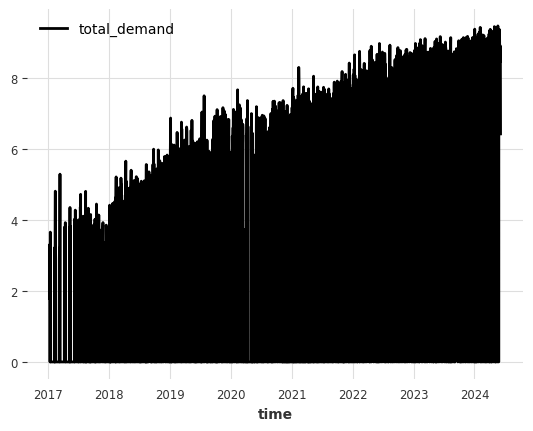

In [ ]:
series.plot()

<Axes: xlabel='time'>

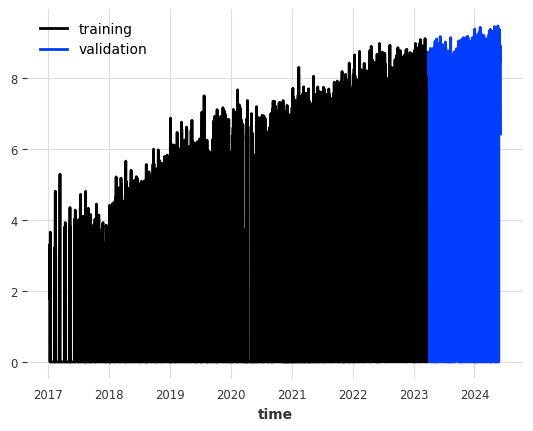

In [ ]:
test_sample_size = 62*7
train, val = series[:-test_sample_size], series[-test_sample_size:]
train.plot(label="training")
val.plot(label="validation")

<Axes: xlabel='time'>

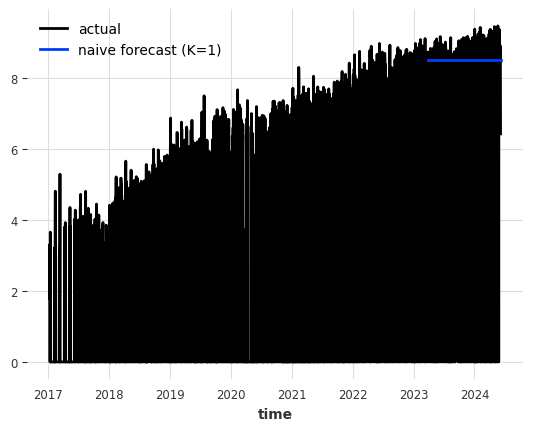

In [ ]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(test_sample_size)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

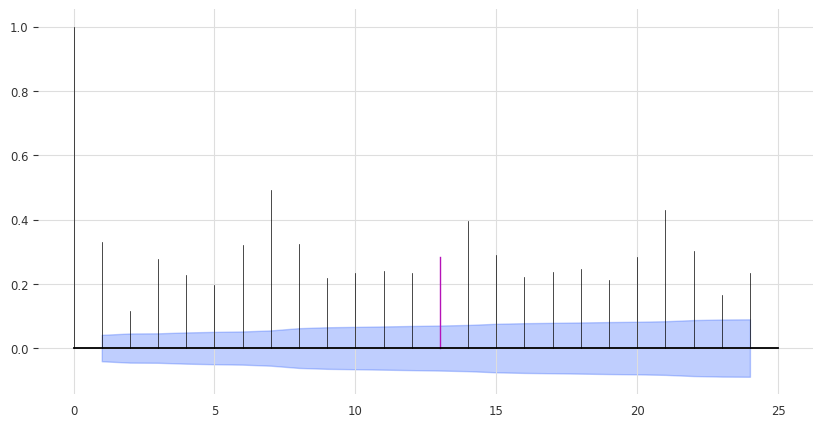

In [ ]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=13, alpha=0.05, max_lag=24, )

In [ ]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 3.
There is seasonality of order 7.
There is seasonality of order 11.
There is seasonality of order 14.
There is seasonality of order 18.
There is seasonality of order 21.


<Axes: xlabel='time'>

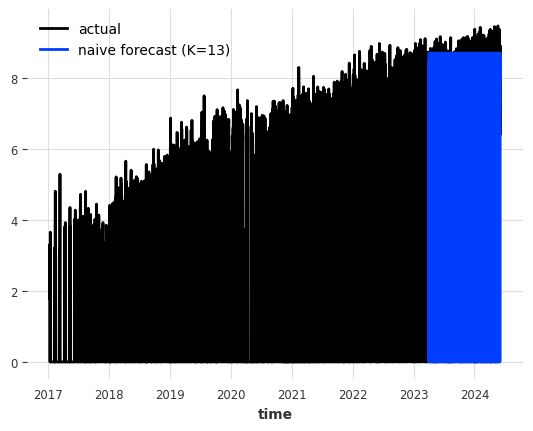

In [ ]:
seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(test_sample_size)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=13)")

<Axes: xlabel='time'>

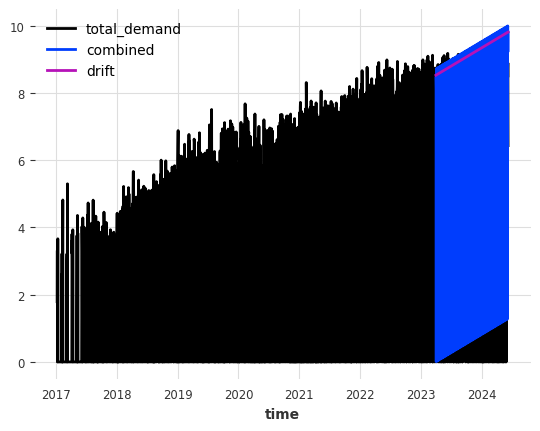

In [ ]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(test_sample_size)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [ ]:
inverse_fn = lambda x: np.exp(x) - 1

In [ ]:
from darts.metrics import mae

print(
    f"Mean absolute for the combined naive drift + seasonal: {mae(series.map(inverse_fn), seasonal_forecast.map(inverse_fn)):.2f}kgs."
)

Mean absolute for the combined naive drift + seasonal: 2491.02kgs.


# Prophet

In [ ]:
future_cov = datetime_attribute_timeseries(train, "day", cyclic=True, add_length=test_sample_size)
# adding a seasonality (daily, weekly and yearly are included by default) and holidays
model = Prophet(
    add_seasonalities={
        'name':"monthly",
        'seasonal_periods': 30,
        'fourier_order':12
        },
)
model.fit(train, future_covariates=future_cov)

07:24:44 - cmdstanpy - INFO - Chain [1] start processing
07:24:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet(add_seasonalities={'name': 'monthly', 'seasonal_periods': 30, 'fourier_order': 12}, country_holidays=None, suppress_stdout_stderror=True, add_encoders=None, cap=None, floor=None)

In [ ]:
pred = model.predict(test_sample_size, future_covariates=future_cov)

<Axes: xlabel='time'>

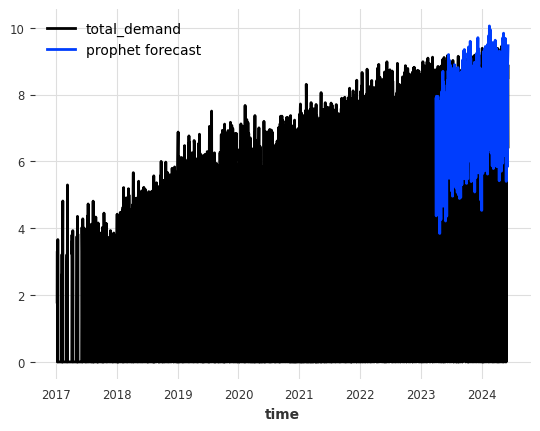

In [ ]:
series.plot()
pred.plot(label="prophet forecast")

In [ ]:
from darts.metrics import mae

print(
    f"Mean absolute for the combined naive drift + seasonal: {mae(series.map(inverse_fn), pred.map(inverse_fn)):.2f}kgs."
)

Mean absolute for the combined naive drift + seasonal: 3285.25kgs.
